In [57]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin

import sklearn.metrics as metrics

from gensim import utils
import gensim.parsing.preprocessing as gsp

import joblib

from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models import CoherenceModel

import re

# Functions

# Load data

In [2]:
# Read csv and create list of tags 
df = pd.read_csv('in/StackOverflow_50000_posts.csv')
df = df[['Id', 'Title', 'Body', 'Tags']]

df['Post'] = df['Title'] + ' ' + df['Body']
df.drop(columns = ['Title', 'Body'], inplace = True)

df['Tags'] = df['Tags'].str.findall(r'<(.*?)>')
df['nTags'] = df['Tags'].apply(len)

In [3]:
# df = df.loc[0:7999, :]
n_posts = df['Id'].count()

In [4]:
# Create tags matrix of size n_obs * n_tags
mlb = MultiLabelBinarizer(sparse_output = False)
df_tags = pd.DataFrame(mlb.fit_transform(df['Tags']), columns = mlb.classes_, index = df.index)

# Analyze tags

In [5]:
# Sort df_tags per number of occurences 
df_tags_unique = pd.DataFrame(df_tags.sum(axis = 0).sort_values(ascending = False), columns = ['n_occurence'])
df_tags = df_tags[df_tags_unique.index]

In [6]:
# Calculate cumulative percentage of tags
n_total_tags = df_tags.sum().sum()
df_tags_unique['pct_tags'] = df_tags_unique.cumsum(axis = 0) / n_total_tags * 100
n_total_tags

153341

In [7]:
# Calculate what % of posts are covered by at least one tag 
df_tmp = pd.DataFrame(index = df_tags.index, columns = ['Tagged'])
df_tmp['Tagged'] = 0

for col in df_tags:
    df_tmp['Tagged'] = df_tmp['Tagged'] | df_tags[col]
    df_tags_unique.loc[col, 'n_posts'] = df_tmp['Tagged'].sum()
    
df_tags_unique['pct_posts'] = df_tags_unique['n_posts'] / n_posts * 100

# Reset index to create tag col
df_tags_unique = df_tags_unique.reset_index().rename(columns = {'index': 'tag'})

n_tags_unique = df_tags_unique['tag'].count()
n_tags_unique

13379

In [8]:
df_tags_unique

,tag,n_occurence,pct_tags,n_posts,pct_posts
0,python,7619,4.968665,7619.0,15.238
1,javascript,5654,8.655872,13237.0,26.474
2,java,3604,11.006189,16796.0,33.592
3,c#,2722,12.781317,19460.0,38.920
4,html,2298,14.279938,20540.0,41.080
...,...,...,...,...,...
13374,modulus,1,99.997391,50000.0,100.000
13375,mojo-useragent,1,99.998044,50000.0,100.000
13376,mollie,1,99.998696,50000.0,100.000
13377,mongo-dart,1,99.999348,50000.0,100.000


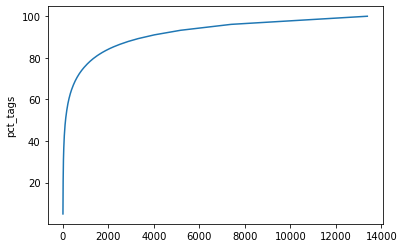

In [9]:
sns.lineplot(x = df_tags_unique.index + 1, y = df_tags_unique['pct_tags'])

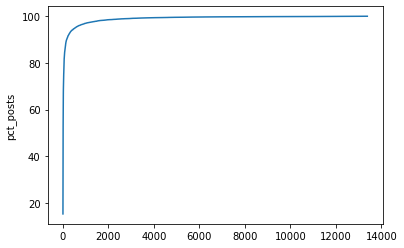

In [10]:
sns.lineplot(x = df_tags_unique.index + 1, y = df_tags_unique['pct_posts'])

In [11]:
df_tags_unique.loc[199, :]

tag            optimization
n_occurence              96
pct_tags            56.8485
n_posts               45464
pct_posts            90.928
Name: 199, dtype: object

# Modelling

## First subset of tags to limit the data set and get an unbiased test set

In [12]:
list_top = df_tags_unique.loc[0:199, 'tag']

df_tags = df_tags[list_top]

keep_index = df_tags[df_tags.sum(axis = 1) != 0].index

X = df.loc[keep_index, 'Post']
y = df_tags.loc[keep_index, :]

In [13]:
# Define a train and test set based on those tags
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1500, random_state = 0)

## Function to define tag and number of observations subset for train and val

In [14]:
# Create a train and validation set, optionally with a limited number of tags 
def train_val_tag_subset(X_train, y_train, df_tags_unique, n_tags, n_train, n_val): 
    # Limit train and val to tag subset 
    list_top = df_tags_unique.loc[0:n_tags-1, 'tag']
    y_train = y_train[list_top]
    keep_index = y_train[y_train.sum(axis = 1) != 0].index
    X_train = X_train[keep_index]
    y_train = y_train.loc[keep_index, :]
    
    # Limit size of train and val
    X_train = X_train.sample(n = n_train + n_val, random_state = 55)
    y_train = y_train.loc[X_train.index, :]
    
    # Define a train and test set based on those tags
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = n_val, random_state = 0)
    
    return X_train, y_train, X_val, y_val

In [15]:
# Create train and validation set of given size
# No tag subset used in unsupervised learning
X_train, y_train, X_val, y_val = train_val_tag_subset(X_train, y_train, df_tags_unique, 
                                                      n_tags = len(list_top), n_train = 2500, n_val = 2000)

## Model

In [16]:
# Remove '-' from RE_PUNCT in order to adapt the gensim strip_punctuation filter 
#  and conserve words like machine-learning, deep-learning ... 

In [17]:
gsp.RE_PUNCT

re.compile(r'([!"\#\$%\&\'\(\)\*\+,\-\./:;<=>\?@\[\\\]\^_`\{\|\}\~])+',
re.UNICODE)

In [18]:
punctuation = r"""!"#$%&'()*+,./:;<=>?@[\]^_`{|}~"""
gsp.RE_PUNCT = re.compile(r'([%s])+' % re.escape(punctuation), re.UNICODE)

In [19]:
gsp.RE_PUNCT

re.compile(r'([!"\#\$%\&\'\(\)\*\+,\./:;<=>\?@\[\\\]\^_`\{\|\}\~])+',
re.UNICODE)

In [20]:
# Define and apply gensim filters
filters = [
           gsp.strip_tags, 
           gsp.strip_punctuation,
           gsp.strip_multiple_whitespaces,
           gsp.strip_numeric,
           gsp.remove_stopwords, 
           gsp.strip_short, 
#            gsp.stem_text
          ]

def clean_text(s):
    s = s.lower()
    s = utils.to_unicode(s)
    for f in filters:
        s = f(s)
    
    s = s.split()
    
    return s

# Custom transformer using gensim filters
class TextCleaner(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

In [21]:
Z = ['machine-learning']
TextCleaner().transform(Z)

[['machine-learning']]

In [22]:
data_lemmatized = TextCleaner().transform(X_train)

# Create Dictionary
id2word = Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [23]:
# Text is in the form of a list of words 
data_lemmatized[55][0:10]

['php',
 'create',
 'formatted',
 'xml',
 'sql',
 'result',
 'problem',
 'struggling',
 'days',
 'create']

In [24]:
# Corpus representation counts the frequency of each word in each text 
print(corpus[:1])

[[(0, 2), (1, 1), (2, 1), (3, 4), (4, 3), (5, 1), (6, 1), (7, 1), (8, 2), (9, 1), (10, 3), (11, 3), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 2), (18, 4), (19, 2), (20, 2), (21, 5), (22, 2), (23, 2), (24, 2), (25, 2), (26, 2), (27, 3), (28, 1), (29, 1), (30, 1), (31, 1), (32, 15), (33, 1), (34, 1), (35, 2), (36, 2), (37, 1), (38, 2), (39, 1), (40, 1), (41, 2), (42, 1), (43, 1), (44, 2), (45, 3), (46, 1), (47, 2), (48, 1), (49, 12), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 6), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 10), (64, 1), (65, 2), (66, 2), (67, 2), (68, 1), (69, 1), (70, 4), (71, 1), (72, 4), (73, 4), (74, 1), (75, 2), (76, 1), (77, 4), (78, 1), (79, 2), (80, 2), (81, 1), (82, 1), (83, 5), (84, 3), (85, 2), (86, 2), (87, 4), (88, 2), (89, 1), (90, 2), (91, 4), (92, 1), (93, 1), (94, 4), (95, 1), (96, 1), (97, 1), (98, 2), (99, 2), (100, 2), (101, 2), (102, 1), (103, 1), (104, 1), (105, 1), (106, 12), (107, 2), (108, 1), (109, 2), (110

In [25]:
%%time

# Build LDA model
lda_model = LdaModel(corpus = corpus, id2word=id2word, num_topics = 50, random_state = 100, 
                         chunksize = 100, passes = 10, per_word_topics = True)

Wall time: 32.3 s


In [26]:
lda_model.print_topics()

[(41,
  '0.098*"style" + 0.094*"position" + 0.083*"padding" + 0.077*"relative" + 0.072*"z-index" + 0.013*"class" + 0.011*"flutter" + 0.010*"icon" + 0.010*"anonymous" + 0.010*"crossorigin"'),
 (20,
  '0.028*"version" + 0.015*"build" + 0.014*"bin" + 0.014*"usr" + 0.012*"command" + 0.011*"error" + 0.010*"artifactid" + 0.009*"following" + 0.009*"example" + 0.008*"http"'),
 (38,
  '0.066*"view" + 0.045*"text" + 0.026*"style" + 0.023*"color" + 0.016*"size" + 0.012*"value" + 0.012*"grid" + 0.012*"var" + 0.011*"image" + 0.011*"index"'),
 (7,
  '0.190*"self" + 0.027*"pygame" + 0.027*"def" + 0.023*"event" + 0.018*"init" + 0.015*"color" + 0.014*"key" + 0.012*"rect" + 0.012*"pyqt" + 0.012*"import"'),
 (46,
  '0.145*"image" + 0.022*"img" + 0.021*"png" + 0.020*"message" + 0.019*"user" + 0.016*"images" + 0.013*"groups" + 0.012*"open" + 0.011*"nice" + 0.010*"true"'),
 (11,
  '0.019*"folder" + 0.017*"click" + 0.017*"button" + 0.017*"message" + 0.015*"new" + 0.011*"certificate" + 0.009*"checkout" + 0.00

In [27]:
%%time

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model = lda_model, texts = data_lemmatized, dictionary = id2word, coherence = 'c_v')

coherence_lda = coherence_model_lda.get_coherence()

print('Coherence Score: ', coherence_lda)

Coherence Score:  0.416829893767364
Wall time: 11.5 s


In [28]:
# Determine tags associated with each topic by checking if any existing tag is present in the topic top words
def calc_lda_tags(lda_model, list_top, n_top_words = 15): 
    # Initialize tag list, each element will be the list of tags associated to a topic of the lda_model
    lda_tags = []
    
    # For every topic
    for i in range(0, lda_model.num_topics):
        
        topic_tags = []
        
        # Add all top words identical to a tag to topic_tags
        for word, proba in lda_model.show_topic(i, topn = n_top_words):
            if (list_top == word).sum() == 1:
                topic_tags.append(word)
        
        lda_tags.append(topic_tags)
    
    return lda_tags

lda_tags = calc_lda_tags(lda_model, list_top, n_top_words = 15)
lda_tags

[['api', 'database'],
 ['list', 'plot', 'html', 'function'],
 [],
 ['string', 'class', 'list'],
 ['javafx', 'java'],
 ['android', 'string'],
 ['file', 'php', 'python', 'function'],
 ['pygame'],
 ['xml'],
 ['list', 'json'],
 ['java', 'gradle', 'api', 'string'],
 ['file'],
 ['function', 'git'],
 ['python', 'file', 'tensorflow', 'django'],
 [],
 ['azure', 'string'],
 [],
 ['matrix', 'dataframe', 'list'],
 ['class', 'string', 'list', 'java'],
 ['android', 'string', 'datetime', 'file'],
 ['http', 'file', 'maven'],
 ['object', 'json', 'function'],
 [],
 ['testing'],
 [],
 ['dictionary'],
 ['class'],
 ['vector', 'string'],
 ['file', 'sql', 'http'],
 ['list', 'dataframe', 'class'],
 ['class'],
 ['excel', 'http'],
 ['function'],
 ['function'],
 [],
 ['image', 'keras', 'html'],
 ['class', 'string'],
 ['string'],
 ['image'],
 ['date', 'java', 'string', 'spring'],
 ['list', 'object', 'pygame'],
 ['class', 'flutter'],
 ['sql', 'database'],
 ['class', 'html', 'css'],
 [],
 [],
 ['image'],
 ['java', 

In [29]:
# Predict a list of tags for a single document in bow format using the lda_model and the tags associated to each topic
def lda_tag_pred(lda_model, document, lda_tags, min_proba = 0):
    # Get document topics from lda_model
    topics_pred = lda_model.get_document_topics(document)
    
    # Get topic tags for every topic with proba greater than min_proba and combine them in a list
    tags_pred = []
    for topic_nb, proba in topics_pred:
        if proba > min_proba :
            tags_pred.extend(lda_tags[topic_nb])
    
    # Remove potential duplicates
    tags_pred = list(set(tags_pred))
    
    return tags_pred

In [30]:
# Predict the tags for multiple documents using the lda_model, return a df identical in size to y
def lda_y_pred(lda_model, X, y, id2word, lda_tags, mlb, min_proba = 0):
    # Initialize output
    y_pred = pd.DataFrame(0, columns = y.columns, index = y.index)
    
    # Create a corpus in bow format from X
    X_prep = TextCleaner().transform(X)
    corpus = [id2word.doc2bow(text) for text in X_prep]
    
    # Predict tags for every document in the corpus
    tags_pred = []
    for document in corpus: 
        tags_pred_tmp = lda_tag_pred(lda_model, document, lda_tags, min_proba = min_proba)
        tags_pred.append(tags_pred_tmp)
    
    # Transform list of tags into a y_pred matrix using the MultiLabelBinarizer fitted earlier
    # Only keep the columns present in y to have y_pred comparable to y
    y_pred = pd.DataFrame(mlb.transform(tags_pred), columns = mlb.classes_, index = y.index).loc[:, y.columns]
    
    return y_pred

In [31]:
y_pred = lda_y_pred(lda_model, X_test, y_test, id2word, lda_tags, mlb, min_proba = 0.2)

In [32]:
y_pred

,python,javascript,java,c#,html,r,c++,pandas,android,php,...,parsing,http,angular-material,aggregation-framework,ansible,axios,matrix,ionic-framework,angular8,optimization
42104,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16052,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37308,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3458,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
8358,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17062,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10526,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40717,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
35391,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
y_pred.sum().sum()

4070

In [34]:
jaccard = metrics.jaccard_score(y_test, y_pred, average = 'weighted')
jaccard

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:778: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples.
  'true or predicted', average, ('jaccard',))


0.04762834734311543

num_topics : 5

num_topics : 15

Wall time: 1min 12s


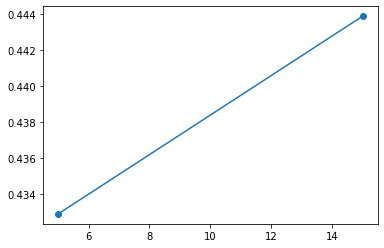

In [54]:
%%time

# Evaluate coherence for different values of num_topics
coherence = []
list_num_topics = [5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100, 120, 140, 160]
list_num_topics = [5, 15]
num_topics_opt = 0

max_jaccard = 0 
list_n_top_words = [5, 10, 15]
n_top_words_opt = 0
list_min_proba = [0, 0.1, 0.2]
min_proba_opt = 0

for num_topics in list_num_topics:
    print('num_topics : {}\n'.format(num_topics))
    # Train LDA model
    lda_model = LdaModel(corpus = corpus, id2word = id2word, num_topics = num_topics, random_state = 100, 
                             chunksize = 100, passes = 10, per_word_topics = True)
    
    # Calculate topic coherence
    coherence_model_lda = CoherenceModel(model = lda_model, texts = data_lemmatized, dictionary = id2word, coherence = 'c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence.append(coherence_lda)
    
    # Apply semi supervised evaluation by calculating jaccard on validation set
    for n_top_words in list_n_top_words: 
        lda_tags = calc_lda_tags(lda_model, list_top, n_top_words = n_top_words)
        
        for min_proba in list_min_proba:
            y_pred = lda_y_pred(lda_model, X_val, y_val, id2word, lda_tags, mlb, min_proba = min_proba)
            
            jaccard = metrics.jaccard_score(y_val, y_pred, average = 'weighted')
            
            if jaccard > max_jaccard:
                max_jaccard = jaccard
                n_top_words_opt = n_top_words
                min_proba_opt = min_proba
                num_topics_opt = num_topics
    
plt.plot(list_num_topics, coherence, marker = 'o')
plt.savefig('coherence.png', bbox_inches = 'tight')

In [55]:
print('max_jaccard :', max_jaccard)
print('num_topics_opt :', num_topics_opt)
print('n_top_words_opt :', n_top_words_opt)
print('min_proba_opt :', min_proba_opt)

max_jaccard : 0.03588684710668714
num_topics_opt : 15
n_top_words_opt : 15
min_proba_opt : 0.1


In [56]:
print(coherence)

[0.4329104853994779, 0.44386020807108256]


# Test model in real life conditions

In [32]:
X_test = ['''How to improve model loss and accuracy? 

I'm currently using a Unet model taken from the kaggle starter code, and modified a couple of parameters to train it on the TACO Dataset for litter. Right now, I'm at a loss as to how I should proceed with optimizing my model. I'm experiencing ridiculous amounts of loss and abysmal accuracy, and I'm not entirely sure which parameters would improve my model's accuracy and loss. The TACO dataset has 60 categories (61 including background). Am I doing something wrong? I'm pretty new to this so any references I could read or advice would be much appreciated.

Here is the code for my model:

IMG_WIDTH = 224
IMG_HEIGHT = 224
IMG_CHANNELS = 3
epochs = 25
validation_steps = val_size
steps_per_epoch = train_size

##Creating the model

initializer = "he_normal"

###Building U-Net Model

##Input Layer
inputs = Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))

##Converting inputs to float
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

##Contraction
c1 = tf.keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer=initializer, padding="same")(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer=initializer, padding="same")(c1)
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer=initializer, padding="same")(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer=initializer, padding="same")(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer=initializer, padding="same")(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer=initializer, padding="same")(c3)
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer=initializer, padding="same")(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer=initializer, padding="same")(c4)
p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3,3), activation="relu", kernel_initializer=initializer, padding="same")(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3,3), activation="relu", kernel_initializer=initializer, padding="same")(c5)

##Expansion
u6 = tf.keras.layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer=initializer, padding="same")(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer=initializer, padding="same")(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer=initializer, padding="same")(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer=initializer, padding="same")(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer=initializer, padding="same")(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer=initializer, padding="same")(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer=initializer, padding="same")(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer=initializer, padding="same")(c9)

##Output Layer
outputs = tf.keras.layers.Dense(61, activation="softmax")(c9)

##Defining Model
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

##Compiling Model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])

##Training the model
results = model.fit(x = train_gen, 
                    validation_data = val_gen, 
                    steps_per_epoch = steps_per_epoch, 
                    validation_steps = validation_steps, 
                    epochs = epochs, 
                    verbose = True)

And here is the accuracy and loss from the first epoch:

Epoch 1/25
 185/1200 [===>..........................] - ETA: 3:30:04 - loss: 388.0077 - accuracy: 9.0721e-04

I'm currently using tensorboard, modelcheckpoint, and earlystopping for callbacks, but unfortunately I don't know how these will help with optimizing my model. Would a larger number of neurons per layer work?
''']

# real tags = python tensorflow machine-learning keras deep-learning
# https://stackoverflow.com/questions/61927516/how-to-improve-model-loss-and-accuracy

In [42]:
y_test = pd.DataFrame(0, columns = y.columns, index = [0])

In [46]:
y_pred = lda_y_pred(lda_model, X_test, y_test, id2word, lda_tags, mlb)

In [51]:
y_pred

,python,javascript,java,c#,html,r,c++,pandas,android,php,...,parsing,http,angular-material,aggregation-framework,ansible,axios,matrix,ionic-framework,angular8,optimization
0,1,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [52]:
for col in y_pred.columns:
    if y_pred[col][0] > 0:
        print(col)

python
java
html
css
django
git
tensorflow
function
keras
class
object
file
vector
matrix


In [33]:
X_test_prep = TextCleaner().transform(X_test)

In [34]:
corpus_test = id2word.doc2bow(X_test_prep[0])

In [35]:
topics_pred = lda_model.get_document_topics(corpus_test)
topics_pred

[(14, 0.015787749),
 (20, 0.011104653),
 (31, 0.096986815),
 (35, 0.16925858),
 (40, 0.65115017),
 (44, 0.03294476)]

In [38]:
tags_pred = []

for topic_nb, proba in topics_pred:
    tags_pred.extend(lda_tags[topic_nb])

# Remove potential duplicates
tags_pred = list(set(tags_pred))

In [39]:
tags_pred

['matrix',
 'html',
 'css',
 'tensorflow',
 'file',
 'django',
 'vector',
 'python',
 'function',
 'git',
 'keras',
 'java',
 'class',
 'object']

# Visualize LDA results using pyLDAvis

Warning : pyLDAvis bug in Jupyter Lab causes it to hide toolbar buttons (cf. https://github.com/bmabey/pyLDAvis/issues/162). 

In [34]:
import pyLDAvis
import pyLDAvis.gensim

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
 
LDAvis_prepared